In [ ]:
%%capture
%pip install python-dotenv neo4j_tools

In [22]:

# Neo4j Connection Setup
from neo4j import GraphDatabase

from dotenv import load_dotenv
import os
load_dotenv('ws.env', override=True)

# Replace these with your Neo4j credentials and connection URI
# Neo4j
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE')

# Create a Neo4j driver instance
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Your Cypher query

print("Checking the connection:")

# Helper function to run and display Cypher query results
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        # Collect results as a list
        records = [record.data() for record in result]
        # Print the records
        for record in records:
            print(record)
        return records

# Run the query; check the connection
query = "MATCH p=()-[]-() limit 1 RETURN p"
results = run_query(query)

Checking the connection:
{'p': [{'countryCode': 'US', 'companyName': 'ACME Biologics', 'iso3Code': 'USA'}, 'SUPPLIES_RM', {'generation': 'g1', 'productSKU': 'df4be3de-0c6b-4d2c-ac71-db4b9fbdf395', 'package': 'all', 'form': 'Tablet', 'strength': '5mg', 'materialType': 'RM', 'description': 'Iolescidib Tablet 5mg', 'location': 'Philadelphia PA/US', 'globalBrand': 'Iolescidib', 'rmSequence': 1}]}


## Understanding Pharma Supply Chain Model
This graph model maps the full lifecycle of a pharmaceutical product, connecting key entities like suppliers, raw materials, APIs, product stages (BULK → DP → FG), batches, equipment, and distributors. Relationships capture flows such as SUPPLIES_RM, PRODUCT_FLOW, and DISTRIBUTED_BY, enabling analysis of dependencies, bottlenecks, and end-to-end supply chain visibility.

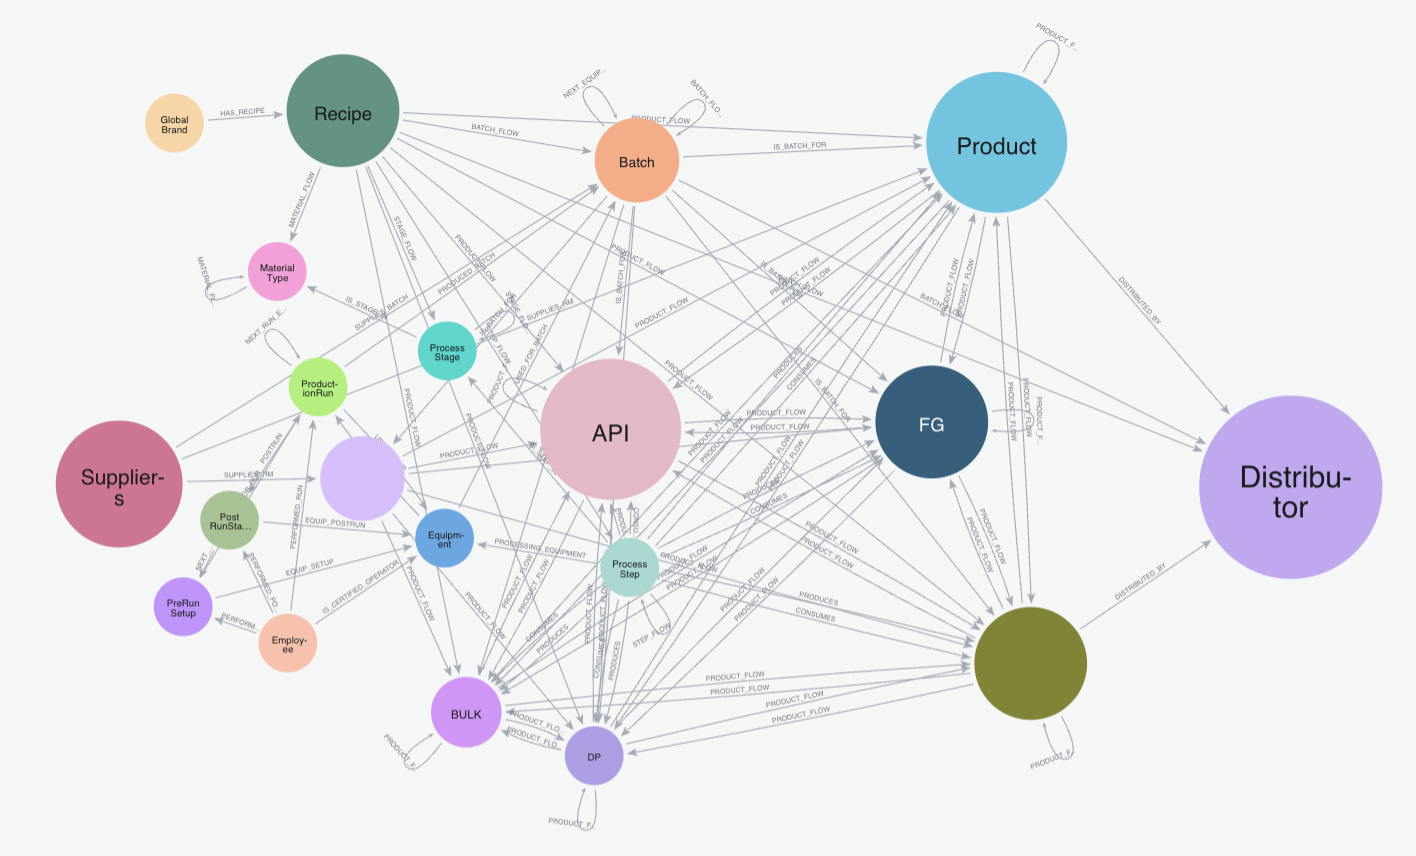

In [ ]:
query = "call db.schema.visualization()"
results = run_query(query)

## Find the Dependency Chain
**Suppliers->Raw Materials->API->Drug Products->Finished Product->Distributors**

This query traces the **dependency chain** for a specific product, showing how it flows from **Suppliers** through **Raw Materials** to the final **Product**, and then to **Distributors**.  It helps identify critical **upstream and downstream dependencies** in the supply chain for a given `productSKU`

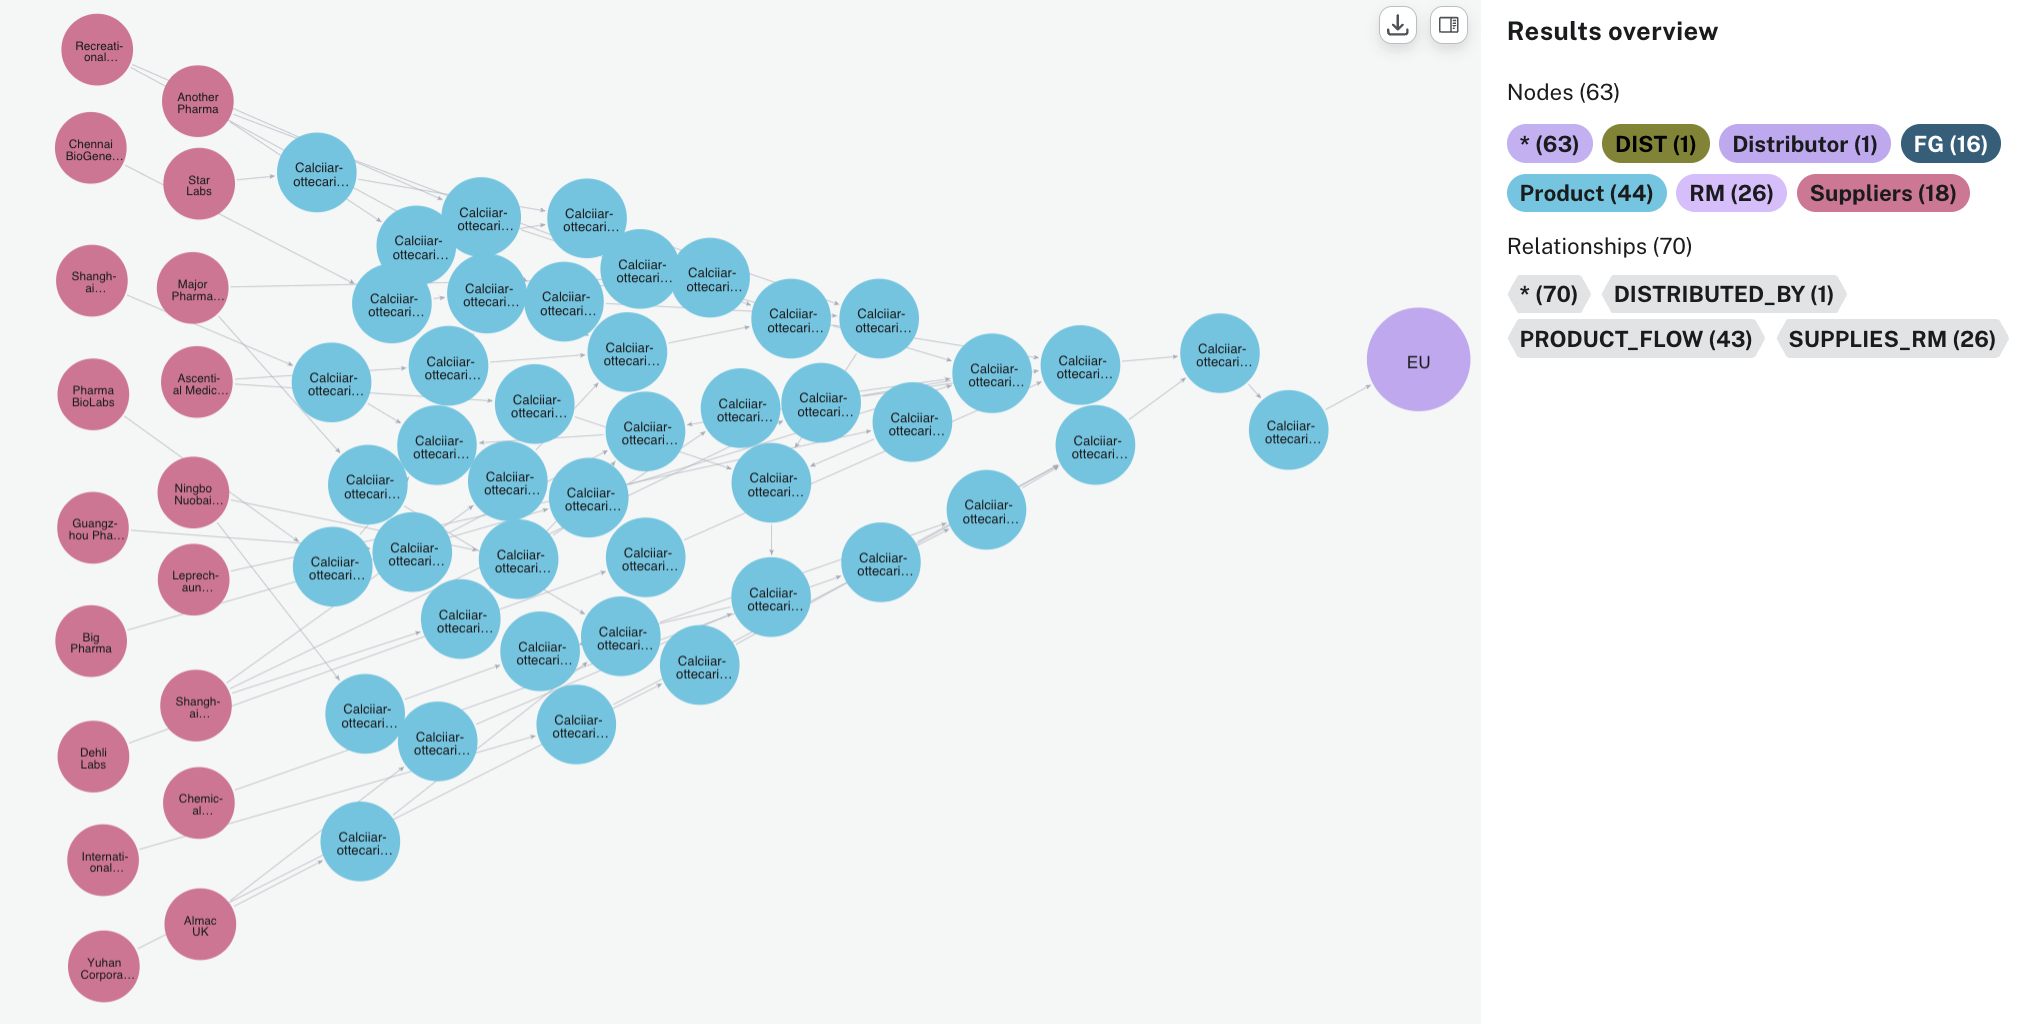

In [ ]:
query = """
MATCH path = (sup:Suppliers)-[:SUPPLIES_RM]->(rm:RM)-[:PRODUCT_FLOW*]->(prod:Product)-[:DISTRIBUTED_BY]->(dist:Distributor)
WHERE prod.productSKU = '7e882292-ae98-45eb-8119-596b5d8b73e1'
RETURN nodes(path) AS nodes, relationships(path) AS relationships
"""

results = run_query(query)

In [ ]:
#Find dependency chain from Suppliers -> RM -> API -> Finished Goods-> Distributor for a given Supplier 
#MATCH path = (sup:Suppliers)-[:SUPPLIES_RM]->(rm:RM)-[:PRODUCT_FLOW*]->(fg:DIST)-[:DISTRIBUTED_BY]->(dist:Distributor)
#where sup.companyName = 'Palmetto Pharmaceuticals'

#RETURN path;

## Identify Raw Materials with limited Suppliers *(Dependency Bottleneck)* 

This query finds *raw materials (RMs)* that are supplied by *only one supplier*, indicating a potential *supply chain bottleneck* or *dependency risk*.  It counts how many suppliers exist for each RM and filters for those with only one (`supplierCount = 1`).  
The result includes the *raw material's SKU*, *brand name*, and the number of suppliers, helping stakeholders identify and mitigate *single points of failure* in sourcing.

In [ ]:
query = """
MATCH (rm:RM)<-[:SUPPLIES_RM]-(sup:Suppliers)
WITH rm, COUNT(sup) AS supplierCount
WHERE supplierCount = 1
RETURN rm.productSKU AS rawMaterialSKU, 
       rm.globalBrand AS rawMaterialName, 
       supplierCount
ORDER BY supplierCount
"""

run_query(query)

## Find APIs that are used in multiple Drug Products and could create a supply bottleneck?
This query identifies Active Pharmaceutical Ingredients (APIs) that are used across multiple Drug Products. APIs with broad usage can pose a scarcity risk if supply becomes limited.By filtering for APIs used in more than 4 products (productCount > 4), this query helps highlight high-dependency ingredients that could become critical bottlenecks in the supply chain.

The results include the API’s SKU, brand name, and the number of dependent products — sorted by dependency severity

In [23]:
query = """
MATCH (api:API)-[:PRODUCT_FLOW]->(dp:DP)
WITH api, COUNT(dp) AS productCount
WHERE productCount > 4
RETURN api.productSKU AS apiSKU, 
       api.globalBrand AS apiName, 
       productCount
ORDER BY productCount DESC
"""
run_query(query)

{'apiSKU': 'a316fa8d-0d6b-4db7-b75f-01eaf6cc5220', 'apiName': 'Perfluicoxib', 'productCount': 6}
{'apiSKU': 'fc136fc7-545d-4d29-b0d1-aeaa0ad1d50a', 'apiName': 'Perfluicoxib', 'productCount': 6}
{'apiSKU': '2a97a429-1f27-41de-a1e4-c7f044fe7c3f', 'apiName': 'Somcoiampa', 'productCount': 5}
{'apiSKU': '8d5efaf0-03c5-4b3a-b121-2e0c6ac3829a', 'apiName': 'Somcoiampa', 'productCount': 5}
{'apiSKU': '02b96392-3343-4226-837b-a9bf992ffc22', 'apiName': 'Somcoiampa', 'productCount': 5}


[{'apiSKU': 'a316fa8d-0d6b-4db7-b75f-01eaf6cc5220',
  'apiName': 'Perfluicoxib',
  'productCount': 6},
 {'apiSKU': 'fc136fc7-545d-4d29-b0d1-aeaa0ad1d50a',
  'apiName': 'Perfluicoxib',
  'productCount': 6},
 {'apiSKU': '2a97a429-1f27-41de-a1e4-c7f044fe7c3f',
  'apiName': 'Somcoiampa',
  'productCount': 5},
 {'apiSKU': '8d5efaf0-03c5-4b3a-b121-2e0c6ac3829a',
  'apiName': 'Somcoiampa',
  'productCount': 5},
 {'apiSKU': '02b96392-3343-4226-837b-a9bf992ffc22',
  'apiName': 'Somcoiampa',
  'productCount': 5}]

## High Dependecy Risk with just 1 supplier

In [ ]:
// 1. Find APIs used in multiple Drug Products (scarcity risk)
// 2. Check how many suppliers provide each API = Active Pharmaceutical Ingredient
// 3. Flag APIs that have only one supplier (high dependency risk)

MATCH (sup:Suppliers)-[:SUPPLIES_RM]->(rm:RM)-[:PRODUCT_FLOW]->(api:API)-[:PRODUCT_FLOW]->(dp:DP)
WITH api, COUNT(dp) AS productCount, COLLECT(DISTINCT dp) AS dpList, COUNT(DISTINCT sup) AS supplierCount, COLLECT(DISTINCT sup.companyName) AS supplierList
WHERE productCount > 4  // Arbitrary threshold for major dependency
RETURN api.productSKU AS apiSKU, 
       api.globalBrand AS apiName, 
       productCount, 
       supplierCount, 
       supplierList,
       CASE 
           WHEN supplierCount = 1 THEN '⚠️ Single Supplier Bottleneck!!** '
           ELSE 'Multiple Suppliers Available'
       END AS SupplierRisk
ORDER BY productCount DESC;

## ShotestPath from RM-> Product (DIST) with distributor

In [ ]:
// Find the shortest path from raw materials to a particular finished product SKU. Show the distributor at the end just to pinpoint the end of the path! 
MATCH path = shortestPath((s:RM)-[:PRODUCT_FLOW* ]->(p:Product {productSKU: "7e882292-ae98-45eb-8119-596b5d8b73e1"}))
OPTIONAL MATCH (d:Distributor)<-[dist:DISTRIBUTED_BY]-(p)
RETURN path,dist, d

## Raw Materials Demand Back Pressure

In [ ]:
// Determine the raw material quantity required to fulfill demand at the distributor level, considering the entire supply chain (from raw materials → production → distribution). It also identifies suppliers of these raw materials and how the demand flows backward through the supply network
// * Designed to analyze Raw Materials Demand Back Pressure, which essentially tracks how demand at the distribution level affects raw material needs upstream in the supply chain


MATCH (d:Distributor)<-[db:DISTRIBUTED_BY]-(prod:Product)
WHERE prod.productSKU = '9a6b431f-3a38-4b45-9451-fbf39b2e2fd0'

MATCH (api)<-[pf2:PRODUCT_FLOW]-(rm:RM)
WHERE pf2.globalBrand = prod.globalBrand
  AND pf2.strength = prod.strength
  AND pf2.form = prod.form
  AND pf2.generation = prod.generation

WITH d, db.demandQty AS demandQty, db, prod, COLLECT(DISTINCT rm) AS RMList
UNWIND RMList AS curRM

MATCH p = shortestPath((prod)<-[pf1:PRODUCT_FLOW*]-(curRM))
MATCH p3 = (myProd:Product)<-[pf:PRODUCT_FLOW]-(curRM)<-[:SUPPLIES_RM]-(sup:Suppliers)
WHERE pf.globalBrand = prod.globalBrand
  AND pf.strength = prod.strength
  AND pf.form = prod.form
  AND pf.generation = prod.generation
  AND pf.market = d.market

RETURN sup.companyName AS supplierName,
       curRM.productSKU AS rawMaterialSKU,
       apoc.coll.disjunction(["Product"], labels(myProd))[0] AS usedBy,
       demandQty,
       REDUCE(rmQty = demandQty, rel IN relationships(p) |
         TOINTEGER(ROUND(rmQty / (COALESCE(rel.conversionRatio, 1.0)), 0))
       ) AS rawMaterialQty
ORDER BY usedBy, supplierName, rawMaterialSKU;